In [1]:
import math
import torch
import itertools
import torchvision

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.autograd import Variable
from sklearn.metrics import confusion_matrix

import Models as models

%matplotlib inline

### Data Preparation

In [2]:
def to_tensor(data,test_size=945,filters=1,height=5100):
    """
    This function transform the initial data into tensor form.
    """
    data_size = data.shape[0]
    dimensions = data.shape[1]
    
    train_data = data.iloc[test_size:, :dimensions-1].to_numpy()
    test_data = data.iloc[:test_size,:dimensions-1].to_numpy()
    train_labels = torch.from_numpy(data.iloc[test_size:, dimensions-1].to_numpy())
    test_labels = torch.from_numpy(data.iloc[:test_size,dimensions-1].to_numpy())
    
    train_data = torch.from_numpy(train_data.reshape(data_size-test_size,filters,height)).type(torch.FloatTensor)
    test_data = torch.from_numpy(test_data.reshape(test_size,filters,height)).type(torch.FloatTensor)
    
    train_ds = torch.utils.data.TensorDataset(train_data, train_labels)
    test_ds = torch.utils.data.TensorDataset(test_data, test_labels)

    train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    return train_loader, test_loader

# hyper paramters
EPOCH = 1200
BATCH_SIZE = 32
cudaopt = True

# data preparation
print('==> Preparing data..')
data = pd.read_csv("E:/Scientific research/D-paper/code/shiyusupp5100.csv")
train_loader, test_loader = to_tensor(data,height=5100,test_size=945)
print('==> Data already loaded')

# model training
def train_model(model,train_loader,test_loader,optimizer,scheduler,EPOCH):
    torch.cuda.set_device(0)
    
    # record test accuracy
    acc_train = np.zeros((EPOCH,))
    acc_test = np.zeros((EPOCH,))
    loss_train = np.zeros((EPOCH,))
    loss_test = np.zeros((EPOCH,))
    outm_temp = torch.zeros((0,7))
    pred_all_temp = torch.zeros((0,1))
    labels_by = torch.zeros((0,1))
    
    # training and testing
    current_acc = 0
    for epoch in range(EPOCH):
        
        # training
        model.train()
        correct = 0
        train_loss = 0
        for step, (x, y) in enumerate(train_loader):
            b_x = Variable(x)
            b_y = Variable(y)
            if cudaopt:
                b_y, b_x = b_y.cuda(), b_x.cuda()
            scores,outplot = model(b_x)
            loss = F.nll_loss(scores, b_y)
            optimizer.zero_grad()           
            loss.backward()                 
            optimizer.step() 
            model.zero_grad()
            
            # compute training accuracy
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            train_loss += F.nll_loss(scores,b_y,reduction='sum').data.item()
        scheduler.step()

        acc_train[epoch] = 100 * float(correct) / float(len(train_loader.dataset))
        loss_train[epoch] = train_loss/len(train_loader.dataset)
    
        # testing
        model.eval()
        with torch.no_grad():
            correct = 0
            test_loss = 0
            for step, (x, y) in enumerate(test_loader):
                b_x = Variable(x)
                b_y = Variable(y)  # batch label
                if cudaopt:
                    b_y, b_x = b_y.cuda(), b_x.cuda()
                scores,outplotm = model(b_x)
                outm_temp = torch.cat((outm_temp, outplotm.cpu()), dim=0)
                test_loss += F.nll_loss(scores, b_y, reduction='sum').data.item()
                pred = scores.data.max(1, keepdim=True)[1]
                pred_all_temp = torch.cat((pred_all_temp,pred.cpu()), dim=0)
                labels_by = torch.cat((labels_by,b_y.data.view_as(pred).cpu()), dim=0)
                correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
                test_loss += F.nll_loss(scores,b_y,reduction='sum').data.item() 
        
        outplotte = outm_temp
        y_predict = pred_all_temp
        y_act = labels_by
        outm_temp = torch.zeros((0,7))
        pred_all_temp = torch.zeros((0,1))
        labels_by = torch.zeros((0,1))
        acc_test[epoch] = 100 * float(correct) / float(len(test_loader.dataset))
        loss_test[epoch] = test_loss/len(test_loader.dataset)

#         print('Epoch: ', epoch, 
#               ' | train acc: ', round(acc_train[epoch],2), '%', 
#               ' | test acc: ', round(acc_test[epoch],2), '%',
#               ' | train loss: ', round(Loss_train[epoch],4), 
#               ' | test loss: ', round(Loss_test[epoch],4))

        if acc_test[epoch] > 98 and acc_test[epoch] > current_acc:
            num = epoch
            outplotf = outplotte
            ylabel=y_act
            current_acc = acc_test[epoch]
            torch.save(model.state_dict(), 'C:/Users/Han/Desktop/cx/dcscmodel_3_3.pkl')
            cm = confusion_matrix(y_act, y_predict)
            
    return model,acc_train,acc_test,cm,current_acc

==> Preparing data..
==> Data already loaded


### Model - DCSCNet

In [3]:
model = models.DCSCNet(32,3,1,7)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=150,gamma=0.75)

model,acc_train,acc_test,cm,current_acc = train_model(model.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Results
#### Accuracy plot

98.94179894179894


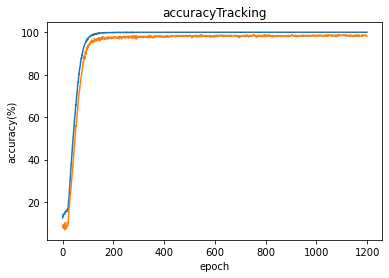

In [4]:
print(current_acc)
fig,ax = plt.subplots()
ax.plot(acc_train[:])
ax.plot(acc_test[:])

ax.set(xlabel='epoch',ylabel='accuracy(%)', title='accuracyTracking')

plt.show()

#### Confusion matrix

In [5]:
def plot_confusion_matrix(cm, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
        horizontalalignment = 'center',
        color = "white" if cm[i,j] > thresh else "black")

    fig.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[135   0   0   0   0   0   0]
 [  0 133   0   0   0   2   0]
 [  0   0 132   3   0   0   0]
 [  0   0   1 134   0   0   0]
 [  0   0   1   0 132   2   0]
 [  0   0   1   0   0 134   0]
 [  0   0   0   0   0   0 135]]


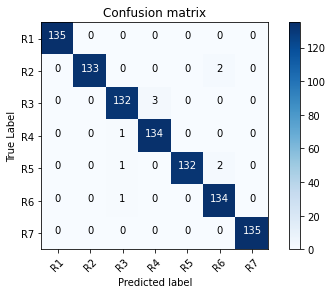

In [6]:
fig = plt.gcf()
cm_labels = ['R1','R2','R3','R4','R5','R6','R7']
plot_confusion_matrix(cm, classes=cm_labels, title='Confusion matrix')